# Capstone project - HealthCare Fraud Detection : Logistic Regression

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_roc_curve,roc_auc_score,f1_score
from sklearn.metrics import classification_report as cl_rep_skl
from imblearn.pipeline import Pipeline,make_pipeline
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.classifier import confusion_matrix, classification_report, ROCAUC
from yellowbrick.model_selection import CVScores
from cp_clean_helper import show_values
from LGR_helper import std_num_cols, rb_scale_cols, model_results, get_confusion_matrix
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

### # Loading datasets, dropping few columns, and looking at shapes:-

In [2]:
# Loading datasets

train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)

# Dropping some ID related features and created new model dfs

traindf = train_df.drop(['BeneID','ClaimID','Provider'], axis=1)
testdf = test_df.drop(['BeneID','ClaimID','Provider'], axis=1)

# Looking at dataset shapes

print('Shape of original train data :',train_df.shape)
print('Shape of original test data :',test_df.shape)
print('Shape of model train data :',traindf.shape)
print('Shape of model test data :',testdf.shape)

Shape of original train data : (558211, 61)
Shape of original test data : (135392, 60)
Shape of model train data : (558211, 58)
Shape of model test data : (135392, 57)


### # Separating independant and dependant variables:-

In [3]:
## Label Encoding PotentialFraud

label_encoder = preprocessing.LabelEncoder()
traindf['PotentialFraud'] = label_encoder.fit_transform(traindf['PotentialFraud'])

## Separating x and y variables for test train split

LGR_x = traindf.drop(['PotentialFraud'], axis=1)
LGR_y = traindf['PotentialFraud']

In [4]:
LGR_y # 1: Possible-fraud (Yes), 0: Non-fraud (No)

0         1
1         1
2         1
3         1
4         1
         ..
558206    0
558207    0
558208    0
558209    0
558210    0
Name: PotentialFraud, Length: 558211, dtype: int32

In [5]:
LGR_y.value_counts(normalize=True)*100 # Imbalanced classes

0    61.878931
1    38.121069
Name: PotentialFraud, dtype: float64

### # Train-Test split:

In [6]:
# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(LGR_x, LGR_y, random_state=42,\
                                                shuffle=True, stratify=LGR_y, test_size=0.3)

# Looking at dataset shapes

print('\n')
print('Shape of imbalanced trainX data :',trainX.shape)
print('Shape of imbalanced trainY data :',trainY.shape)
print('Shape of imbalanced testX data :',testX.shape)
print('Shape of imbalanced testY data :',testY.shape)
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY) :',trainY.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY) :',testY.value_counts(normalize=True)*100)
print('\n')
print("*"*60)



Shape of imbalanced trainX data : (390747, 57)
Shape of imbalanced trainY data : (390747,)
Shape of imbalanced testX data : (167464, 57)
Shape of imbalanced testY data : (167464,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY) : 0    61.878914
1    38.121086
dtype: float64
Class ratio - Fraud/Non-Fraud (testY) : 0    61.878971
1    38.121029
dtype: float64


************************************************************


In [7]:
# Dropping some additional features to evaluate performance

trainX = trainX.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                            'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                            'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                            'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'], axis=1)

testX = testX.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                          'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                          'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                          'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                          'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                          'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'], axis=1)

### # SMOTE Upsampling:

In [8]:
# Upsampling the minority class via SMOTE

trainX_SM, trainY_SM = SMOTE(random_state=0, k_neighbors=7).fit_resample(trainX, trainY)
testX_SM, testY_SM = SMOTE(random_state=0, k_neighbors=7).fit_resample(testX, testY)

# Upsampling the minority class via Borderline SMOTE

trainX_BSM, trainY_BSM = BorderlineSMOTE(random_state=0).fit_resample(trainX, trainY)
testX_BSM, testY_BSM = BorderlineSMOTE(random_state=0).fit_resample(testX, testY)

# Looking at dataset shapes

print('\n')
print('Shape of SMOTE balanced trainX data :',trainX_SM.shape)
print('Shape of SMOTE balanced trainY data :',trainY_SM.shape)
print('Shape of SMOTE balanced testX data :',testX_SM.shape)
print('Shape of SMOTE balanced testY data :',testY_SM.shape)
print('Shape of Borderline SMOTE balanced trainX data :',trainX_BSM.shape)
print('Shape of Borderline SMOTE balanced trainY data :',trainY_BSM.shape)
print('Shape of Borderline SMOTE balanced testX data :',testX_BSM.shape)
print('Shape of Borderline SMOTE balanced testY data :',testY_BSM.shape, end='\n')
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY_SM) :',trainY_SM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_SM) :',testY_SM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (trainY_BSM) :',trainY_BSM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_BSM) :',testY_BSM.value_counts(normalize=True)*100, end='\n')
print('\n')
print("*"*60)



Shape of SMOTE balanced trainX data : (483580, 44)
Shape of SMOTE balanced trainY data : (483580,)
Shape of SMOTE balanced testX data : (207250, 44)
Shape of SMOTE balanced testY data : (207250,)
Shape of Borderline SMOTE balanced trainX data : (483580, 44)
Shape of Borderline SMOTE balanced trainY data : (483580,)
Shape of Borderline SMOTE balanced testX data : (207250, 44)
Shape of Borderline SMOTE balanced testY data : (207250,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY_SM) : 0    50.0
1    50.0
dtype: float64
Class ratio - Fraud/Non-Fraud (testY_SM) : 0    50.0
1    50.0
dtype: float64
Class ratio - Fraud/Non-Fraud (trainY_BSM) : 0    50.0
1    50.0
dtype: float64
Class ratio - Fraud/Non-Fraud (testY_BSM) : 0    50.0
1    50.0
dtype: float64


************************************************************


In [21]:
# Setting x and y variables

x = trainX_SM 
y = trainY_SM

# Setting model required parameters

base_logitsm = LogisticRegression(solver='liblinear', random_state=0)

# Setting the parameter grid

grid_para_logit = [{
    "C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]}]

# Running the RF model through the grid search

grid_search_logit = GridSearchCV(base_logitsm, grid_para_logit,\
                                  cv=5, scoring='f1_weighted',\
                                  return_train_score = True, n_jobs=-1)

grid_search_logit.fit(x, y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000, 1000000,
                                100000000]}],
             return_train_score=True, scoring='f1_weighted')

In [22]:
# The best parameters

grid_search_logit.best_params_

{'C': 0.0001}

In [23]:
# The best score

grid_search_logit.best_score_

0.6667583208541055

In [24]:
# Best estimator training/test errors

print("The training error is: %.5f" % (1 - grid_search_logit.best_estimator_.score(x, y)))
print("The test     error is: %.5f" % (1 - grid_search_logit.best_estimator_.score(testX_SM, testY_SM)))

The training error is: 0.31059
The test     error is: 0.31123


In [25]:
# Selecting the best model from the Grid Search as the final model

final_lgr = grid_search_logit.best_estimator_

# Model with all features and BSM:

model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, final_lgr, show=True)

The Model Results for  LogisticRegression(C=0.0001, random_state=0, solver='liblinear')
************************************************************
Train Accuracy is equal to 0.637
Test Accuracy is equal to 0.638
The Precision score is 0.650
The Average Precision score is 0.590
The Recall score is 0.597
The F1 score is 0.622
The AUC/ROC score is 0.638
True-Positive: 61836.000
True-Negative: 70368.000
False-Positive: 33257.000
False-Negative: 41789.000
Correctly Classified: 132204.000
Incorrectly Classified: 75046.000


[0.636630960751065, 0.6378962605548854, 0.6502686843405929, 0.5967285886610374]

In [28]:
# Actual value

thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.49175501609464667

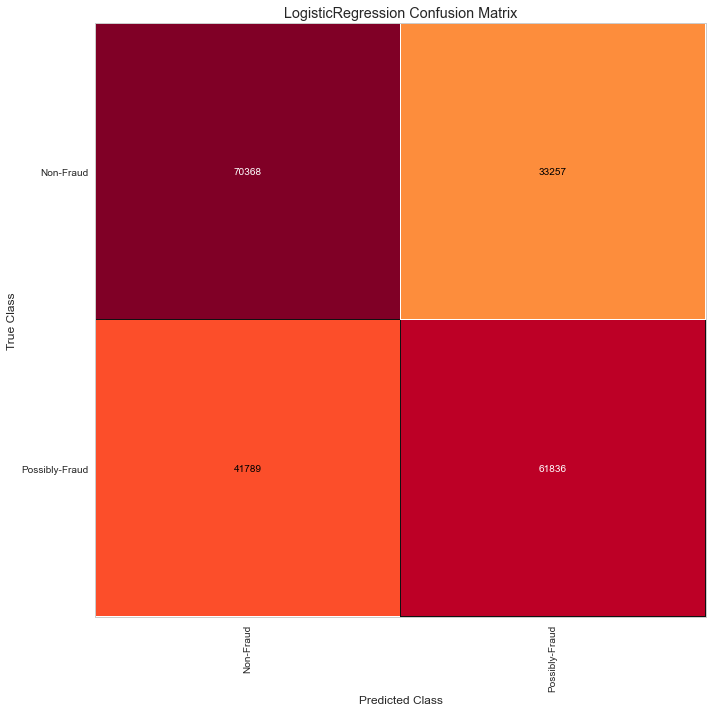

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [29]:
# Visualizing the confusion matrix with Yellowbricks (thres=0.5)

plt.figure(figsize = (10,10))
viz = confusion_matrix(
    final_lgr,
    trainX_BSM, trainY_BSM, testX_BSM, testY_BSM,
    classes=['Non-Fraud', 'Possibly-Fraud'])
viz.show()

In [31]:
# Looking at confusion matrix (thres=0.5)

cm1 = get_confusion_matrix(final_lgr, testX_BSM, testY_BSM)
cm1

array([[70368, 33257],
       [41789, 61836]], dtype=int64)

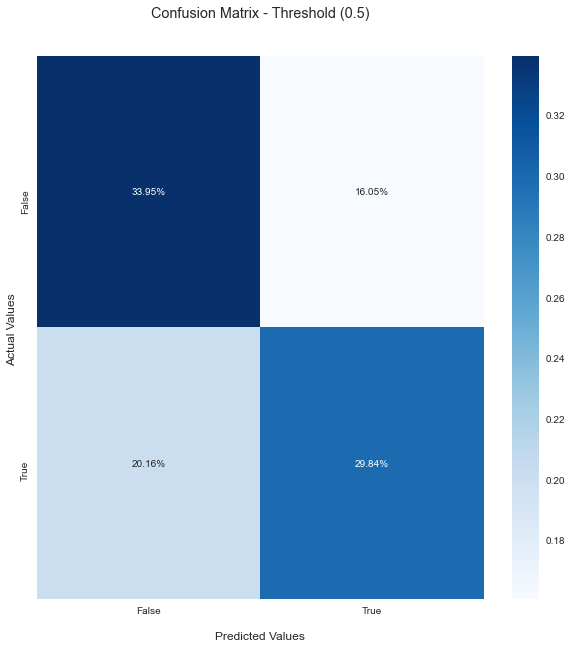

In [32]:
#Plotting the confusion matrix

labels = ['Non-Fraud', 'Possibly-Fraud']

plt.figure(figsize = (10,10))

ax = sns.heatmap(cm1/np.sum(cm1), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix - Threshold (0.5)\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

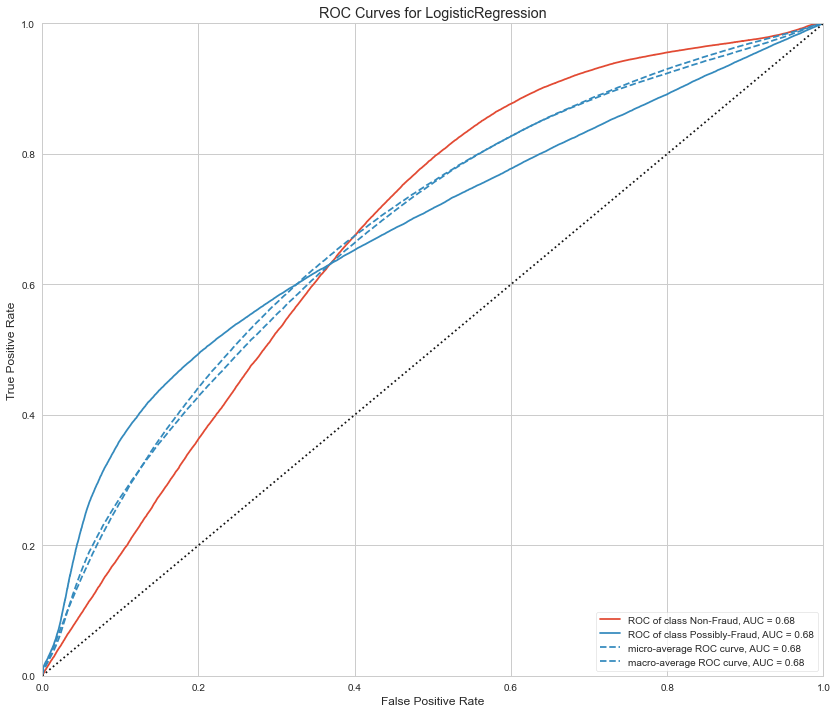

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [35]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))
sns.set_style("whitegrid")

visualizer = ROCAUC(final_lgr, classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.fit(trainX_BSM, trainY_BSM)        # Fit the training data to the visualizer
visualizer.score(testX_BSM, testY_BSM)        # Evaluate the model on the test data
visualizer.show()                             # Finalize and render the figure

# Feature Selection with RFE

In [57]:
from sklearn.feature_selection import RFE

# Extracting top 10 best features with RFE:

rfe = RFE(estimator=final_lgr, n_features_to_select=20, step=10)

# Running model to compare performance

model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rfe, show=True)

The Model Results for  RFE(estimator=LogisticRegression(C=0.0001, random_state=0, solver='liblinear'),
    n_features_to_select=20, step=10)
************************************************************
Train Accuracy is equal to 0.687
Test Accuracy is equal to 0.688
The Precision score is 0.820
The Average Precision score is 0.654
The Recall score is 0.481
The F1 score is 0.606
The AUC/ROC score is 0.688
True-Positive: 49848.000
True-Negative: 92646.000
False-Positive: 10979.000
False-Negative: 53777.000
Correctly Classified: 142494.000
Incorrectly Classified: 64756.000


[0.6874850076512676, 0.687546441495778, 0.819504496358525, 0.4810422195416164]

In [58]:
# Looking at RFE feature selection

print(trainX_BSM.columns[rfe.support_])

Index(['Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'Deceased', 'Age',
       'DOB_year', 'DOB_month', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'ClmProcedureCode_3', 'Hospital_Stay', 'Claim_Duration',
       'Claim_Start_Year', 'Claim_Start_Month', 'Total_Claim_Amt',
       'Physician_Count', 'Claim_Count', 'Hospital_Count', 'Chr_Cond_Count'],
      dtype='object')


### # Feature Selection with SelectKBest

In [59]:
from sklearn.feature_selection import SelectKBest

# Extracting top 20 best features by applying SelectKBest class

bestfeatures = SelectKBest(k=20)
fit = bestfeatures.fit(trainX_BSM, trainY_BSM)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(trainX_BSM.columns)

#concat two dataframes

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #printing 10 best features

                  Features        Score
0                   Gender  4155.367117
17       DeductibleAmtPaid  3143.514624
18      DiagnosisGroupCode  2616.581556
34           Hospital_Stay  1831.444690
2    RenalDiseaseIndicator  1776.854552
39         Total_Claim_Amt  1646.432963
12  InscClaimAmtReimbursed  1481.391703
29      ClmProcedureCode_1  1242.842004
43          Chr_Cond_Count  1190.657100
3                    State   942.408093
27      ClmDiagnosisCode_9   866.579043
26      ClmDiagnosisCode_8   865.828705
25      ClmDiagnosisCode_7   781.247777
24      ClmDiagnosisCode_6   570.252578
23      ClmDiagnosisCode_5   461.329510
30      ClmProcedureCode_2   439.161461
37       Claim_Start_Month   433.789779
16   ClmAdmitDiagnosisCode   422.414040
42          Hospital_Count   389.001931
10               DOB_month   376.744869


In [60]:
# Model using SelectKBest 20 features

selected_feat = featureScores.nlargest(20,'Score')['Features'].to_list()

model_results(trainX_BSM[selected_feat], trainY_BSM, testX_BSM[selected_feat], testY_BSM, final_lgr, show=True)

The Model Results for  LogisticRegression(C=0.0001, random_state=0, solver='liblinear')
************************************************************
Train Accuracy is equal to 0.621
Test Accuracy is equal to 0.622
The Precision score is 0.639
The Average Precision score is 0.578
The Recall score is 0.560
The F1 score is 0.597
The AUC/ROC score is 0.622
True-Positive: 57997.000
True-Negative: 70922.000
False-Positive: 32703.000
False-Negative: 45628.000
Correctly Classified: 128919.000
Incorrectly Classified: 78331.000


[0.621165060589768, 0.6220458383594692, 0.6394377067254686, 0.5596815440289505]